In [1]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.io as sio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from __future__ import division
import random
import scipy
import h5py
import hdf5storage

In [3]:
## random seed will dictate the random initialization
sd=30000
np.random.seed(sd)

In [4]:
maxker=28

# Select the appropriate training data file

traindatapath='/home/ubuntu/Notebooks/Circuit3A_Training_Data.h5'
# traindatapath='/home/ubuntu/Notebooks/Circuit3B_Training_Data.h5' 


data = hdf5storage.loadmat(traindatapath)


x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = reshape(data['y_test'], [1, 2000])

gc_bias_init = data['gc_bias']
bipkernels = data['bipkernels']
bip_gc_syn_init = data['bip_gc_syn']
bip_am_syn_init = data['bip_am_syn']
am_gc_syn_init = data['am_gc_syn']

#sparsity params for weight matrix initializations
init_sparsity = 0.0 
init_sparsity_bg = 0.01


bip_gc_syn_mask1 = np.random.rand(maxker*100, 1)
bip_gc_syn_mask1 = reshape(bip_gc_syn_mask1, [1, 10, 10, maxker])
bip_gc_syn_mask1 = bip_gc_syn_mask1 >(1.0 - init_sparsity_bg)


bip_gc_syn_init_full = np.zeros([1, 10, 10, maxker])
bip_gc_syn_mask_true = reshape(bip_gc_syn_init, [1, 10, 10, 3])>0.0
bip_gc_syn_init_full[:, :, :, 0:3] = bip_gc_syn_mask_true

bip_gc_syn_mask = np.maximum(bip_gc_syn_mask1, bip_gc_syn_init_full)

bip_gc_syn_init11 = tf.random_uniform([1, 10, 10, maxker], minval=1.0, maxval=2.0, dtype=tf.float32)
bip_gc_syn_init1=bip_gc_syn_init11

bip_am_syn_mask = np.zeros([10, 10, maxker, 5, 5])
for i in range(10):
    for j in range(10):
        for k in range(maxker):
            bip_am_syn_mask[i, j, k, int(floor(i/2)), int(floor(j/2))] = 1.0
bip_am_syn_mask = bip_am_syn_mask.astype(float32)


bip_am_syn_inds = np.zeros([maxker*100, 6])
for i in range(10):
    for j in range(10):
        for k in range(maxker):
            bip_am_syn_inds[maxker*10*(i)+28*(j)+k]=[0, i, j, k, floor(i/2), floor(j/2)]
bip_am_syn_inds = bip_am_syn_inds.astype(int64)


bip_am_syn_init11 = abs(np.random.normal(0.0, (sqrt(2.0)/112.0), size=[maxker*100]))
bip_am_syn_init11=bip_am_syn_init11.astype(float32)        

am_gc_syn_init1 = tf.random_uniform([1, 5, 5], minval=0.1, maxval=0.2, dtype=tf.float32)
 

print(shape(x_train))
print(shape(x_test))
print(shape(bip_gc_syn_init))

sum(bip_am_syn_mask)

(98000, 100, 100, 1)
(2000, 100, 100, 1)
(1, 10, 10, 3)


2800.0

(1, 98000)
(1, 2000)


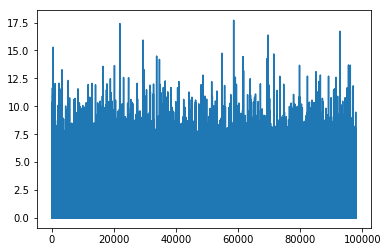

In [5]:
print(shape(y_train))
print(shape(y_test))
plt.figure()
plt.plot(squeeze(y_train))

In [6]:
def bias_var(shape, initial_val):
    initial = tf.constant(initial_val, shape=shape)
    return tf.constant(initial_val) #initial

def bip_conv2d(x, W):
    padsize=10 
    paddedx=tf.pad(x, [[0, 0], [padsize, padsize], [padsize, padsize], [0, 0]], 'CONSTANT')
    outconv=tf.nn.conv2d(paddedx, W, strides=[1, 10, 10, 1], padding='SAME') #250 for movingdot and noise
    return outconv[:, 1:11, 1:11, :]

def synapse_var(shape, initial_val):
#      initial=tf.constant(initial_val, shape=shape)
#     initial = tf.random_uniform(shape, minval=0.1, maxval=0.8, dtype=tf.float32)
    return tf.Variable(initial_val)


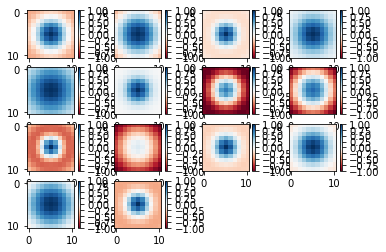

In [7]:
## create layer 1 convolutional kernels (difference of gaussians)

def difference_of_gaussians(ctr_sigma, surr_sigma, ctr_strength, surr_strength, x, y):
    
    center=0.4*(1/ctr_sigma)*exp(-0.5*square(sqrt(square(x)+square(y))/ctr_sigma))
    
    surround=0.4*(1/surr_sigma)*exp(-0.5*square(sqrt(square(x)+square(y))/surr_sigma))
    
    kernel = ctr_strength*center - surr_strength*surround
    
    maxk = amax(abs(kernel)) #normalization factor
    
    return kernel/maxk


x = np.linspace(-5, 5, 11)
y = np.linspace(-5, 5, 11)
xv, yv = np.meshgrid(x, y)

bipkernels = np.zeros([11, 11, 1, maxker])


kernel1 = difference_of_gaussians(3, 6, 13, 12.9, xv, yv) 
kernel2 = difference_of_gaussians(5, 6, 18, 18, xv, yv)
kernel3 = difference_of_gaussians(2, 4, 20, 14, xv, yv)
kernel4 = difference_of_gaussians(3, 6, 13, 0, xv, yv)
kernel5 = difference_of_gaussians(4, 6, 13, 0, xv, yv) 
kernel6 = difference_of_gaussians(2, 4, 20, 0, xv, yv)

kernel7 = difference_of_gaussians(3, 6, 13, 20, xv, yv)
kernel8 = difference_of_gaussians(5, 6, 18, 20, xv, yv) 
kernel9 = difference_of_gaussians(2, 4, 20, 24, xv, yv)

kernel10 = difference_of_gaussians(5, 8, 13, 20, xv, yv)
kernel11 = difference_of_gaussians(2, 8, 15, 15, xv, yv)
kernel12 = difference_of_gaussians(3, 8, 20, 12, xv, yv)
kernel13 = difference_of_gaussians(5, 8, 20, 18, xv, yv)
kernel14 = difference_of_gaussians(2, 8, 13, 18, xv, yv)


bipkernels[:, :, 0, 0]=kernel1
bipkernels[:, :, 0, 1]=kernel2
bipkernels[:, :, 0, 2]=kernel3
bipkernels[:, :, 0, 3]=kernel4
bipkernels[:, :, 0, 4]=-1.0*kernel1
bipkernels[:, :, 0, 5]=-1.0*kernel2
bipkernels[:, :, 0, 6]=-1.0*kernel3
bipkernels[:, :, 0, 7]=-1.0*kernel4
bipkernels[:, :, 0, 8]=kernel5
bipkernels[:, :, 0, 9]=kernel6
bipkernels[:, :, 0, 10]=kernel7
bipkernels[:, :, 0, 11]=kernel8
bipkernels[:, :, 0, 12]=-1.0*kernel5
bipkernels[:, :, 0, 13]=-1.0*kernel6
bipkernels[:, :, 0, 14]=-1.0*kernel7
bipkernels[:, :, 0, 15]=-1.0*kernel8
bipkernels[:, :, 0, 16]=kernel9
bipkernels[:, :, 0, 17]=kernel10
bipkernels[:, :, 0, 18]=kernel11
bipkernels[:, :, 0, 19]=kernel12
bipkernels[:, :, 0, 20]=-1.0*kernel9
bipkernels[:, :, 0, 21]=-1.0*kernel10
bipkernels[:, :, 0, 22]=-1.0*kernel11
bipkernels[:, :, 0, 23]=-1.0*kernel12
bipkernels[:, :, 0, 24]=kernel13
bipkernels[:, :, 0, 25]=kernel14
bipkernels[:, :, 0, 26]=-1.0*kernel13
bipkernels[:, :, 0, 27]=-1.0*kernel14




plt.figure()
plt.subplot(4, 4, 1)
plt.imshow(kernel1, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 2)
plt.imshow(kernel2, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 3)
plt.imshow(kernel3, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 4)
plt.imshow(kernel4, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 5)
plt.imshow(kernel5, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 6)
plt.imshow(kernel6, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 7)
plt.imshow(kernel7, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 8)
plt.imshow(kernel8, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 9)
plt.imshow(kernel9, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 10)
plt.imshow(kernel10, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 11)
plt.imshow(kernel11, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 12)
plt.imshow(kernel12, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 13)
plt.imshow(kernel13, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()

plt.subplot(4, 4, 14)
plt.imshow(kernel14, cmap=plt.get_cmap('RdBu'))
plt.clim(-1.0, 1.0)
plt.colorbar()


    


    

In [8]:


sess=tf.Session()
sess.run(tf.global_variables_initializer())  


In [9]:
kernels = [3, 8, 16, 28]
lambdas = [1e-1, 1e1, 1e1, 1e1] # knowledge 0.2

datas = [60, 340, 700, 1400, 2800, 5500, 11000, 22000, 98000]
training_epochs = [6000, 4000, 4000, 3000, 3000, 2000, 2000, 1000, 500]
test_sizes = [2080, 2080, 2080, 2080, 2080, 2080, 2080, 2080, 2080, 2000]

learn_rate = 1e-3
learn_rate_late = 1e-4


for i_data in range(7):
    
    for i_kernel in range(4): 
        
        if i_kernel > 0: 
            del stimulus_
            del bipolar_cell_layer
            del gc_activation
            del gc_output
            del bipolar_bias
            del bipkernels1
        
        no_train=datas[i_data]
        epochs = training_epochs[i_data]
        no_kernels = kernels[i_kernel]
        lambda1 = lambdas[i_kernel]
        bipkernels1 = bipkernels[:, :, :, 0:no_kernels]
        bip_gc_syn_init = bip_gc_syn_init1[:, :, :, 0:no_kernels]
        bip_am_syn_mask1 = bip_am_syn_mask[ :, :, 0:no_kernels, :, :]
        
        
        no_test=test_sizes[i_data] 
        no_bipolars = 10
        no_amacrines = 5

        wheretosave = '/home/ubuntu/Notebooks/Circuit3A_Trained_Network_data' + str(no_train) + '_kernel' + str(no_kernels) + '_sd' + str(sd) + '.mat'
#         wheretosave = '/home/ubuntu/Notebooks/Circuit3B_Trained_Network_data' + str(no_train) + '_kernel' + str(no_kernels) + '_sd' + str(sd) + '.mat'

        ## initialize all variables
        bip_bias_init_all = -1.0*np.ones([28])
        bip_bias_init_all[0]=-2.0
        bip_bias_init_all[1]=-3.0
        bip_bias_init_all[3]=-15.0
        bip_bias_init_all[8]=-25.0
        bip_bias_init_all[9]=-10.0
        
        bip_bias_init_all[4]=-2.0
        bip_bias_init_all[5]=-3.0
        bip_bias_init_all[7]=-15.0
        bip_bias_init_all[12]=-25.0
        bip_bias_init_all[13]=-10.0

        
        bip_bias_init = bip_bias_init_all[0:no_kernels]
        bip_bias_init = bip_bias_init.astype(float32)
        bipolar_bias = bias_var([no_kernels], bip_bias_init)
        
        am_bias_init = -5.0 
        am_bias = bias_var([1], am_bias_init)
        
        gc_bias = bias_var([1], gc_bias_init)
        
        bip_gc_syn_init=tf.random.normal([1, no_bipolars, no_bipolars, no_kernels], mean = 0.0, stddev = sqrt(2.0/(no_kernels*100)), dtype=tf.dtypes.float32, seed=sd)
        bip_gc_syn = synapse_var([1, no_bipolars, no_bipolars, no_kernels], bip_gc_syn_init)
        
        bip_am_syn_inds = np.zeros([no_kernels*100, 6])
        for i in range(10):
            for j in range(10):
                for k in range(no_kernels):
                    bip_am_syn_inds[no_kernels*10*(i)+no_kernels*(j)+k]=[0, i, j, k, floor(i/2), floor(j/2)]
        bip_am_syn_inds = bip_am_syn_inds.astype(int64)
        bip_am_syn_init11 = abs(np.random.normal(0.0, (sqrt(2.0/no_kernels)), size=[no_kernels*100]))
        bip_am_syn_init111=0.1*bip_am_syn_init11.astype(float32)  
        bip_am_syn_val = synapse_var([no_kernels*no_bipolars*no_bipolars], bip_am_syn_init111)
        bip_am_syn1 = tf.sparse.SparseTensor(indices=bip_am_syn_inds, values=bip_am_syn_val, dense_shape=[1, no_bipolars, no_bipolars, no_kernels, no_amacrines, no_amacrines])
        bip_am_syn = tf.sparse.to_dense(tf.sparse.reorder(bip_am_syn1))        

        am_gc_syn = synapse_var([1, no_amacrines, no_amacrines], am_gc_syn_init1)

        stimulus_ = tf.placeholder("float32", name="stim_placeholder")

        bipolar_cell_layer = tf.nn.relu(tf.nn.bias_add(bip_conv2d(stimulus_, bipkernels1), bipolar_bias))

        biplyr = tf.reshape(bipolar_cell_layer, [-1, no_bipolars*no_bipolars*no_kernels, 1])

        tilebip_am_syn=tf.tile(tf.transpose(tf.reshape(tf.abs(bip_am_syn), [1, no_bipolars*no_bipolars*no_kernels, no_amacrines*no_amacrines]), [0, 2, 1]), [1, 1, 1])

        amacrine_activation = 3.0*tf.reshape(tf.linalg.matmul(tilebip_am_syn, biplyr), [-1,no_amacrines, no_amacrines])
     
        amacrine_cell_layer = tf.nn.relu(tf.add(amacrine_activation, am_bias))

        gc_activation = tf.multiply(tf.abs(bip_gc_syn), bipolar_cell_layer)

        gc_activation_inhib = tf.multiply(tf.abs(am_gc_syn), amacrine_cell_layer)

        gc_output = tf.nn.relu(tf.add_n([tf.reduce_sum(gc_activation, [1, 2, 3]), -1.0*tf.reduce_sum(gc_activation_inhib, [1, 2])])+gc_bias)

        ## training procedure
        y_ = tf.placeholder("float32", name="output_spikes")
        
        batchsize=20

        loss = (tf.nn.l2_loss((tf.squeeze(gc_output) - tf.squeeze(y_)), name='loss'))

        regularizer=tf.add_n([tf.reduce_sum(tf.abs(bip_am_syn)), tf.reduce_sum(tf.abs(bip_gc_syn)), \
                              0.0*tf.reduce_sum(tf.abs(am_gc_syn))])

        objective=tf.add(loss, lambda1*regularizer)
        
        bip_am_ygrad = tf.gradients(loss, [bip_am_syn])
        bip_am_reggrad = tf.gradients(regularizer, [bip_am_syn])
        
        am_gc_ygrad = tf.gradients(loss, [am_gc_syn])
        am_gc_reggrad = tf.gradients(regularizer, [am_gc_syn])
        
        bip_gc_ygrad = tf.gradients(loss, [bip_gc_syn])
        bip_gc_reggrad = tf.gradients(regularizer, [bip_gc_syn])
        


        algorithm_choice=2
        lr_min = 1e-4
        lr_max = 1e-5
        max_step =500
        lr_ = tf.placeholder("float32", name="learn_rate")
        
        if algorithm_choice==1:
            train_step = tf.train.GradientDescentOptimizer(lr_).minimize(objective)
        elif algorithm_choice==2:
            my_epsilon=1e-8
            train_step = tf.train.AdamOptimizer(learning_rate=lr_, epsilon=my_epsilon).minimize(objective)
        elif algorithm_choice==3:
            momentum_par=0.9
            train_step = tf.train.MomentumOptimizer(lr_, momentum_par).minimize(objective)
        elif algorithm_choice==4:
            train_step = tf.train.AdagradOptimizer(lr_).minimize(objective)
        elif algorithm_choice==5:
            train_step = tf.train.RMSPropOptimizer(lr_).minimize(objective)
            

        sess.run(tf.global_variables_initializer())    

        bip_gc_syn_hist=tf.reshape(bip_gc_syn.eval(session=sess), [1, no_bipolars, no_bipolars, no_kernels]) 
        bip_am_syn_hist=tf.reshape(bip_am_syn.eval(session=sess), [1, no_bipolars, no_bipolars, no_kernels, no_amacrines, no_amacrines]) 
        am_gc_syn_hist=tf.reshape(am_gc_syn.eval(session=sess), [1, no_amacrines, no_amacrines]) 
        train_loss_hist = ones([1])
        test_loss_hist = ones([1])
        
        bip_am_ygrad_hist=np.reshape(sess.run(bip_am_ygrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_bipolars, no_bipolars, no_kernels, no_amacrines, no_amacrines]) 
        bip_am_reggrad_hist=np.reshape(sess.run(bip_am_reggrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_bipolars, no_bipolars, no_kernels, no_amacrines, no_amacrines]) 
        am_gc_ygrad_hist=np.reshape(sess.run(am_gc_ygrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_amacrines, no_amacrines])
        am_gc_reggrad_hist=np.reshape(sess.run(am_gc_reggrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_amacrines, no_amacrines])
        bip_gc_ygrad_hist=np.reshape(sess.run(bip_gc_ygrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_bipolars, no_bipolars, no_kernels]) 
        bip_gc_reggrad_hist=np.reshape(sess.run(bip_gc_reggrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_bipolars, no_bipolars, no_kernels]) 

        train_fd={stimulus_: x_train[0:50, :, :, :]}
        test_fd={stimulus_: x_test[0:50, :, :, :]}
        train_output_hist=reshape(gc_output.eval(session=sess, feed_dict=train_fd), [1, 50])
        test_output_hist=reshape(gc_output.eval(session=sess, feed_dict=test_fd), [1, 50])
        
        
        check=1.0
        step=0
        end_flag=0

        fd = {stimulus_:x_train[0:100, :, :, :], y_:y_train[0, 0:100]}
        train_loss_val = sess.run(loss, feed_dict = fd)
        print(train_loss_val)

        fd = {stimulus_:x_test[0:100, :, :, :], y_:y_test[0, 0:100]}
        test_loss_val = sess.run(loss, feed_dict = fd)
        print(test_loss_val)



        train_loss_hist=train_loss_val*train_loss_hist
        test_loss_hist=test_loss_val*test_loss_hist

        
        endflag=0
        step=0
        while endflag == 0:
            # learning rate schedule
            learn_rate_sch = lr_min + 0.5*(lr_max - lr_min)*(1.0+np.cos(np.pi*(step%max_step/max_step))) 
            if step>=10*max_step:
                learn_rate_sch = lr_min

            inds = np.reshape(np.random.permutation(range(no_train)), [-1, batchsize])
            for n in range(len(inds)): 
                fdd = {stimulus_: x_train[inds[n, :], :, :, :], y_: y_train[0, inds[n, :]], lr_: learn_rate_sch} 
                                                                 
                sess.run(train_step, feed_dict=fdd)

                        
            if (step % 100 ==0):

                train_loss_val = sess.run(loss, feed_dict= {stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]})/100.0
                test_loss_val = sess.run(loss, feed_dict= {stimulus_: x_test[0:100, :, :, :], y_: y_test[0, 0:100]})/100.0
                print("step: %d  loss: = %9f" % (step, train_loss_val))

                bip_gc_syn_hist=tf.concat( [bip_gc_syn_hist, tf.reshape(bip_gc_syn.eval(session=sess), [1, no_bipolars, no_bipolars, no_kernels])], 0,  name='bip_gc_syn_concat')
                bip_am_syn_hist=tf.concat( [bip_am_syn_hist, tf.reshape(bip_am_syn.eval(session=sess), [1, no_bipolars, no_bipolars, no_kernels, no_amacrines, no_amacrines])], 0,  name='bip_am_syn_concat')
                am_gc_syn_hist=tf.concat( [am_gc_syn_hist, tf.reshape(am_gc_syn.eval(session=sess), [1, no_amacrines, no_amacrines])], 0,  name='am_gc_syn_concat')

                bip_am_ygrad_hist=tf.concat( [bip_am_ygrad_hist, np.reshape(sess.run(bip_am_ygrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_bipolars, no_bipolars, no_kernels, no_amacrines, no_amacrines])], 0)
                bip_am_reggrad_hist=tf.concat( [bip_am_reggrad_hist, np.reshape(sess.run(bip_am_reggrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_bipolars, no_bipolars, no_kernels, no_amacrines, no_amacrines])], 0)
                am_gc_ygrad_hist=tf.concat( [am_gc_ygrad_hist, np.reshape(sess.run(am_gc_ygrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_amacrines, no_amacrines])], 0)
                am_gc_reggrad_hist=tf.concat( [am_gc_reggrad_hist, np.reshape(sess.run(am_gc_reggrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_amacrines, no_amacrines])], 0)
                bip_gc_ygrad_hist=tf.concat( [bip_gc_ygrad_hist, np.reshape(sess.run(bip_gc_ygrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_bipolars, no_bipolars, no_kernels])], 0)
                bip_gc_reggrad_hist=tf.concat( [bip_gc_reggrad_hist, np.reshape(sess.run(bip_gc_reggrad, feed_dict={stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}), [1, no_bipolars, no_bipolars, no_kernels])], 0)

                train_loss_hist=np.concatenate([train_loss_hist, np.array([train_loss_val])], axis=0)
                test_loss_hist=np.concatenate([test_loss_hist, np.array([test_loss_val])], axis=0)
                
                train_fd={stimulus_: x_train[0:50, :, :, :]}
                test_fd={stimulus_: x_test[0:50, :, :, :]}
                train_output=reshape(gc_output.eval(session=sess, feed_dict=train_fd), [1, 50])
                test_output=reshape(gc_output.eval(session=sess, feed_dict=test_fd), [1, 50])
                
                train_output_hist=np.concatenate([train_output_hist, train_output], axis=0)
                test_output_hist=np.concatenate([test_output_hist, test_output], axis=0)
                
                # stopping condition
                if (step/100)>=5:
                    b=np.diff(train_loss_hist[int(step/100-5):int(step/100)])
                    a=abs(b)<1.0
                    c=b>=0.0
                    if sum(c)>=3:
                        endflag=1
            step = step + 1


        db = {}

        db['bipolar_bias'] = bipolar_bias.eval(session=sess)
        db['bip_gc_syn_hist'] = bip_gc_syn_hist.eval(session=sess)
        db['bip_am_syn_hist'] = bip_am_syn_hist.eval(session=sess)
        db['am_gc_syn_hist'] = am_gc_syn_hist.eval(session=sess)
        db['gc_bias'] = gc_bias.eval(session=sess)
        
        db['bip_am_ygrad_hist'] = bip_am_ygrad_hist.eval(session=sess)
        db['bip_am_reggrad_hist'] = bip_am_reggrad_hist.eval(session=sess)
        db['am_gc_ygrad_hist'] = am_gc_ygrad_hist.eval(session=sess)
        db['am_gc_reggrad_hist'] = am_gc_reggrad_hist.eval(session=sess)
        db['bip_gc_ygrad_hist'] = bip_gc_ygrad_hist.eval(session=sess)
        db['bip_gc_reggrad_hist'] = bip_gc_reggrad_hist.eval(session=sess)



        db['no_train']=no_train
        db['no_test']=no_test

        db['no_kernels'] = no_kernels
        db['no_bipolars']=no_bipolars

        db['bipkernels'] = bipkernels
        db['randomseed'] = sd

        db['train_output_hist'] = train_output_hist
        db['test_output_hist'] = test_output_hist

        db['algorithm_choice'] = algorithm_choice
        db['learn_rate'] = learn_rate
        db['lambda'] = lambda1

        db['train_loss_hist'] = train_loss_hist
        db['test_loss_hist'] = test_loss_hist                          

        struct_proj = np.zeros([len(train_loss_hist), 1])

        syn_hist = bip_gc_syn_hist.eval(session=sess)
        basyn_hist = abs(bip_am_syn_hist.eval(session=sess))
        agsyn_hist = abs(am_gc_syn_hist.eval(session=sess))
        
        truesyn = np.zeros([10, 10, no_kernels])
        
        truebasyn = np.zeros([no_bipolars, no_bipolars, no_kernels, no_amacrines, no_amacrines])
        truebasyn[:, :, 0:3, :, :]=bip_am_syn_init
        
        trueagsyn=am_gc_syn_init
        
        norm_factor = (np.sum(np.square(truebasyn)) + np.sum(np.square(trueagsyn)))
        for i in range(len(train_loss_hist)):
            norm_factor = (np.sum(np.square(basyn_hist[i, :, :, :, :, :])) + np.sum(np.square(agsyn_hist[i, :, :])))
            struct_proj[i] = (np.sum(np.multiply((basyn_hist[i, :, :, :, :, :]), truebasyn))+np.sum(np.multiply((agsyn_hist[i, :, :]), trueagsyn)))/norm_factor

        db['struct_proj'] = struct_proj

        sio.savemat(wheretosave, db)
        
        print("completed data: %d  kernels: = %9f" % (no_train, no_kernels))
        

40557.617
44305.066
step: 0  loss: = 405.045781
step: 100  loss: = 341.375117
step: 200  loss: = 225.964687
step: 300  loss: = 92.580859
step: 400  loss: = 20.957356
step: 500  loss: =  6.311478
step: 600  loss: =  5.652542
step: 700  loss: =  4.491799
step: 800  loss: =  3.279804
step: 900  loss: =  2.476377
step: 1000  loss: =  2.100222
step: 1100  loss: =  2.066532
step: 1200  loss: =  1.993726
step: 1300  loss: =  1.882496
step: 1400  loss: =  1.770811
step: 1500  loss: =  1.688259
step: 1600  loss: =  1.679344
step: 1700  loss: =  1.659423
step: 1800  loss: =  1.628029
step: 1900  loss: =  1.597695
step: 2000  loss: =  1.578922
step: 2100  loss: =  1.577201
step: 2200  loss: =  1.573769
step: 2300  loss: =  1.569413
step: 2400  loss: =  1.566800
step: 2500  loss: =  1.567256
step: 2600  loss: =  1.567518
step: 2700  loss: =  1.568314
step: 2800  loss: =  1.570559
step: 2900  loss: =  1.575044
completed data: 60  kernels: =  3.000000
82247.01
84920.08
step: 0  loss: = 820.650156
st

step: 3800  loss: =  0.001212
step: 3900  loss: =  0.001012
step: 4000  loss: =  0.000791
step: 4100  loss: =  0.000738
step: 4200  loss: =  0.000673
step: 4300  loss: =  0.000565
step: 4400  loss: =  0.000501
step: 4500  loss: =  0.000417
step: 4600  loss: =  0.000435
step: 4700  loss: =  0.000425
step: 4800  loss: =  0.000424
step: 4900  loss: =  0.000505
step: 5000  loss: =  0.000419
step: 5100  loss: =  0.000460
step: 5200  loss: =  0.000421
step: 5300  loss: =  0.000518
step: 5400  loss: =  0.000419
step: 5500  loss: =  0.000454
step: 5600  loss: =  0.000465
step: 5700  loss: =  0.000403
step: 5800  loss: =  0.000438
completed data: 700  kernels: =  3.000000
85322.82
87507.88
step: 0  loss: = 832.931250
step: 100  loss: =  7.600471
step: 200  loss: =  1.841272
step: 300  loss: =  1.373819
step: 400  loss: =  1.074415
step: 500  loss: =  1.029267
step: 600  loss: =  1.018447
step: 700  loss: =  1.008806
step: 800  loss: =  1.010405
step: 900  loss: =  1.012495
step: 1000  loss: =  

step: 100  loss: =  1.647094
step: 200  loss: =  0.355805
step: 300  loss: =  0.017244
step: 400  loss: =  0.003103
step: 500  loss: =  0.000480
step: 600  loss: =  0.000476
step: 700  loss: =  0.000471
step: 800  loss: =  0.000480
step: 900  loss: =  0.000517
step: 1000  loss: =  0.000463
step: 1100  loss: =  0.000451
step: 1200  loss: =  0.000444
step: 1300  loss: =  0.000465
step: 1400  loss: =  0.000473
step: 1500  loss: =  0.000480
step: 1600  loss: =  0.000473
step: 1700  loss: =  0.000492
completed data: 5500  kernels: =  3.000000
85815.08
89373.66
step: 0  loss: = 710.357031
step: 100  loss: =  1.123627
step: 200  loss: =  0.992466
step: 300  loss: =  0.991336
step: 400  loss: =  0.993093
step: 500  loss: =  1.003790
step: 600  loss: =  0.978749
step: 700  loss: =  0.977553
step: 800  loss: =  0.990114
step: 900  loss: =  0.999619
step: 1000  loss: =  1.000933
step: 1100  loss: =  0.978244
step: 1200  loss: =  0.980263
completed data: 5500  kernels: =  8.000000
215519.86
218757

In [11]:
fd=feed_dict= {stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}
train_output=gc_output.eval(session=sess, feed_dict=fd)
print(train_output)

fd=feed_dict= {stimulus_: x_train[0:100, :, :, :], y_: y_train[0, 0:100]}
train_output=amacrine_cell_layer.eval(session=sess, feed_dict=fd)
print(train_output)

[[0.95063984 0.5828657  0.38144782 0.25167096 0.6110331  0.63634413
  1.1375167  0.37116188 0.3738968  0.36353296 0.16722773 0.4230566
  0.72445667 0.7080679  0.36235395 0.47952414 0.78879434 0.5060988
  0.94206756 0.5335892  1.7905157  0.25151402 0.9466383  0.7494325
  0.69904053 0.5597612  0.5946239  0.6806819  0.4319149  0.5497766
  0.7678618  0.1727006  0.7676616  0.43221897 1.5884638  0.5670322
  1.3228142  0.24523371 0.3425265  0.49594355 0.9181344  1.053214
  0.5079092  0.78113127 1.214992   0.7045511  0.54614013 0.792282
  1.8342131  0.59105015 0.6204924  0.7848783  0.2890526  0.27828673
  0.43007386 0.37421447 1.1664753  0.77967423 0.2872109  0.42856836
  0.1907293  0.7879961  0.6665944  0.5663151  0.63656473 1.2446904
  0.79417825 1.0074445  0.40405294 0.24392527 0.4967049  0.40421417
  0.31279206 0.28556365 0.886541   0.42507738 1.1005278  0.95588815
  0.26616296 0.19438986 1.7633483  0.83045363 1.5218362  0.68291825
  0.66377425 1.0193806  0.96206844 0.20753859 1.376122   0